In [227]:
#Code Prototype for 1D use on EXCLAIM Project, code by Joaquin Matticoli

In [228]:
import numpy as np
import filterpy
#from filterpy.kalman import KalmanFilter as kf
#from filterpy.kalman import predict
#from filterpy.kalman import update
from numpy.random import randn
from filterpy.common import Q_discrete_white_noise
import matplotlib.pyplot as plt
import filterpy.stats as stats
import math
from math import sqrt

In [229]:
from collections import namedtuple
gaussian = namedtuple('Gaussian', ['mean', 'var'])
gaussian.__repr__ = lambda s: '𝒩(μ={:.3f}, 𝜎²={:.3f})'.format(s[0], s[1])

def print_gh(predict, update, z):
    predict_template = '{: 7.3f} {: 8.3f}'
    update_template = '{:.3f}\t{: 7.3f} {: 7.3f}'

    print(predict_template.format(predict[0], predict[1]),end='\t')
    print(update_template.format(z, update[0], update[1]))
    
def predict(posterior, movement): #inputed as gaussians
    x, P = posterior # mean and variance of posterior
    dx, Q = movement # mean and variance of movement
    x = x + dx
    P = P + Q
    return gaussian(x, P)

def update(prior, measurement): #inputed as gaussians
    x, P = prior        # mean and variance of prior
    z, R = measurement  # mean and variance of measurement
    
    y = z - x        # residual
    K = P / (P + R)  # Kalman gain

    x = x + K*y      # posterior
    P = (1 - K) * P  # posterior variance
    return gaussian(x, P)

In [230]:
class PayloadSimulation(object):
    def __init__(self, x0=0, angular_velocity=1,
                 measurement_var=0.0,
                 process_var=0.0):
        """ x0 : initial orientation
            angular_velocity: (+=counterclockwise, -=clockwise)
            measurement_var: variance in measurement deg^2
            process_var: variance in process (deg/s)^2
        """
        self.x = x0
        self.angular_velocity = angular_velocity
        self.meas_std = sqrt(measurement_var)
        self.process_std = sqrt(process_var)

    def move(self, dt=1.0):
        """Compute new orientation of the payload in dt seconds."""
        dx = self.angular_velocity + randn()*self.process_std
        self.x += dx * dt

    def sense_position(self):
        """ Returns measurement of new orientation in degrees."""
        measurement = self.x + randn()*self.meas_std
        return measurement

    def move_and_sense(self):
        """ Move payload, and return measurement of new orientation in degrees"""
        self.move()
        return self.sense_position()

In [231]:
printcase = 1 # If set to 1 it will print out the results
plotcase = 1 # If set to 1 it will plot results

#-----------USER INPUT STARTS------------------------------

process_var = 25. # variance in the payload's movement, idk what number is good for this??
sensor_var = 16. # variance in the sensor
x = gaussian(0., 100.)  # payload's orientation in deg
angular_velocity = 0.5 # angular velocity in deg/s
dt = 1 # time step in seconds
n_iter = 100 # Number of measurements that the sensor will take

#-----------USER INPUT ENDS--------------------------------

process_model = gaussian(angular_velocity*dt, process_var) # displacement to add to x

    #NOTE: sensor variance is in velocity as it measures that so be careful when creating code for that as it's different to other codes
    #NOTE: this code will assume that orientation is always increasing/decreasing and not sinusodial because a more complext Kalman filter is needed for those cases
    
# simulate payload and get measurements
payload = PayloadSimulation(
    x0=x.mean, 
    angular_velocity=process_model.mean, 
    measurement_var=sensor_var, 
    process_var=process_model.var)

# creates list of measurements, NOTE: modify this section if measurements are provided
zs, ztrue = [], []
# ztrue = np.zeros(n_iter)
# zs = np.zeros(n_iter)
for _ in range(n_iter):
    zs.append(payload.move_and_sense())
    ztrue.append(payload.x)
finalposition = payload.x

PREDICT			UPDATE
     x      var		  z	    x      var
  0.500  125.000	4.281	  3.852  14.184
  4.352   39.184	10.015	  8.373  11.361
  8.873   36.361	5.531	  6.552  11.111
  7.052   36.111	2.468	  3.876  11.087
  4.376   36.087	-4.947	 -2.083  11.085
 -1.583   36.085	2.024	  0.916  11.085
  1.416   36.085	7.134	  5.378  11.085
  5.878   36.085	2.771	  3.725  11.085
  4.225   36.085	6.245	  5.624  11.085
  6.124   36.085	4.730	  5.158  11.085
  5.658   36.085	4.373	  4.768  11.085
  5.268   36.085	3.576	  4.096  11.085
  4.596   36.085	10.275	  8.531  11.085
  9.031   36.085	11.106	 10.468  11.085
 10.968   36.085	5.510	  7.187  11.085
  7.687   36.085	9.789	  9.144  11.085
  9.644   36.085	6.692	  7.599  11.085
  8.099   36.085	15.887	 13.495  11.085
 13.995   36.085	13.806	 13.864  11.085
 14.364   36.085	23.629	 20.783  11.085
 21.283   36.085	21.717	 21.584  11.085
 22.084   36.085	22.112	 22.103  11.085
 22.603   36.085	18.491	 19.754  11.085
 20.254   36.085	32.474	 28.720  11.085


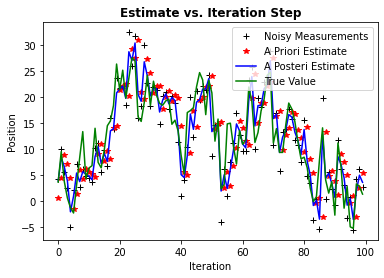

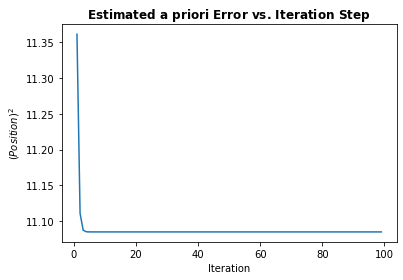

In [232]:
def plotstuff():
    plt.figure()
    plt.plot(zs,'k+',label='Noisy Measurements')
    plt.plot(x1,'r*',label='A Priori Estimate')
    plt.plot(xhat,'b-',label='A Posteri Estimate')
    plt.plot(ztrue,color='g',label='True Value')
    #plt.plot(xhat,'r*',label='prediction')
    plt.legend()
    plt.title('Estimate vs. Iteration Step', fontweight='bold')
    plt.xlabel('Iteration')
    plt.ylabel('Position')
    
    plt.figure()
    valid_iter = range(1,n_iter) # Pminus not valid at step 0
    plt.plot(valid_iter,Pminus[valid_iter],label='A Posteri Error Estimate')
    plt.title('Estimated $\it{\mathbf{a \ priori}}$ Error vs. Iteration Step', fontweight='bold')
    plt.xlabel('Iteration')
    plt.ylabel('$(Position)^2$')
    #plt.setp(plt.gca(),'ylim',[0,.01])
    plt.show()

x1 = np.zeros(n_iter)
#x2 = np.zeros(n_iter)
Pminus = np.zeros(n_iter)
xhat = np.zeros(n_iter)
counter = 0
if printcase == 1:
    print('PREDICT\t\t\tUPDATE')
    print('     x      var\t\t  z\t    x      var')
# perform Kalman filter on measurement z
for z in zs:    
    prior = predict(x, process_model)
    x1[counter] = prior.mean
    likelihood = gaussian(z, sensor_var)
    x = update(prior, likelihood)
    xhat[counter] = x.mean
    Pminus[counter] = x.var
    counter = counter + 1
    if printcase == 1:
        print_gh(prior, x, z)

if printcase == 1:
    print()
    print('final estimate:           {:10.3f}'.format(x.mean))
    print('actual final orientation: {:10.3f}'.format(payload.x))
if plotcase == 1:
    plotstuff()